In [ ]:
import matplotlib.pyplot as plt
import os
from os.path import join
import numpy as np
from PIL import Image
import matplotlib.image as mpimg
from skimage.color import rgb2gray
from skimage.color import label2rgb
from skimage.filters import gaussian
from sklearn.cluster import KMeans
from skimage import img_as_ubyte

In [2]:
plt.close('all')
clear = lambda: os.system('clear')
clear()
np.random.seed(110)

colors = [[1,0,0],[0,1,0],[0,0,1],[0,0.5,0.5],[0.5,0,0.5]] #List of colours

imgNames = ['water_coins','jump','tiger']#{'balloons', 'mountains', 'nature', 'ocean', 'polarlights'};
segmentCounts = [2,3,4,5]

In [3]:
img_num = np.zeros((len(imgNames)*len(segmentCounts)),dtype='int') #stores the last iteration number before convergence of EM
itr_cnt = -1 #iteration counter to traverse img_num

for imgName in imgNames:
    for SegCount in segmentCounts:
        itr_cnt+=1 #increment iteration counter
        # Load the imageusing MatPlotLib        
        img_mtlb = mpimg.imread("Input/" + imgName+ ".png")
        print('Using Matplotlib Image Library: Image is of datatype ',img_mtlb.dtype,'and size ',img_mtlb.shape) # Image is of type float          
        
        # Load the Pillow-- the Python Imaging Library
        img = Image.open("Input/" + imgName+ ".png").convert('RGB')
        print('Using Pillow (Python Image Library): Image is of datatype ',np.asarray(img).dtype,'and size ',img.size) # Image is of type uint8  
        
        
        #%% %Define Parameters
        nSegments = SegCount   # of color clusters in image
        nPixels = img_mtlb.shape[0]*img_mtlb.shape[1];    # Image can be represented by a matrix of size nPixels*nColors
        maxIterations = 20; #maximum number of iterations allowed for EM algorithm.
        nColors = 3;
        #%% Determine the output path for writing images to files
        outputPath = join(''.join(['Output/',str(SegCount), '_segments/', imgName , '/']));
        if not(os.path.exists(outputPath)):
            os.makedirs(outputPath)
        mpimg.imsave(''.join([outputPath,'0.png']),img_mtlb) #save using Matplotlib image library
        #%% Vectorizing image for easier loops- done as im(:) in Matlab
        pixels = img
        pixels = np.array(img).reshape(nPixels,nColors,1)
        
        #%%
        """ Initialize pi (mixture proportion) vector and mu matrix (containing means of each distribution)
            Vector of probabilities for segments... 1 value for each segment.
            Best to think of it like this...
            When the image was generated, color was determined for each pixel by selecting
            a value from one of "n" normal distributions. Each value in this vector 
            corresponds to the probability that a given normal distribution was chosen."""
        
        
        """ Initial guess for pi's is 1/nSegments. Small amount of noise added to slightly perturb 
           GMM coefficients from the initial guess"""
           
        pi = 1/nSegments*(np.ones((nSegments, 1),dtype='float'))
        increment = np.random.normal(0,.0001,1)
        for seg_ctr in range(len(pi)):
            if(seg_ctr%2==1):
                pi[seg_ctr] = pi[seg_ctr] + increment
                if pi[seg_ctr] > 1:
                    pi[seg_ctr] = 1
            else:
                pi[seg_ctr] = pi[seg_ctr] - increment
                if pi[seg_ctr] < 0:
                    pi[seg_ctr] = 0
                
         #%% 
        """Similarly, the initial guess for the segment color means would be a perturbed version of [mu_R, mu_G, mu_B],
           where mu_R, mu_G, mu_B respectively denote the means of the R,G,B color channels in the image.
           mu is a nSegments X nColors matrrix,(seglabels*255).np.asarray(int) where each matrix row denotes mean RGB color for a particcular segment"""
           
        mu = 1/nSegments*(np.ones((nSegments, nColors),dtype='float'))  #for even start
        #add noise to the initialization (but keep it unit)
        for seg_ctr in range(nSegments):
            if(seg_ctr%2==1):
                increment = np.random.normal(0,.0001,1)
            for col_ctr in range(nColors):
                if(seg_ctr%2==1):
                    mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) + increment
                else:
                    mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) - increment;             
        

        #%% EM-iterations begin here. Start with the initial (pi, mu) guesses        
        
        mu_last_iter = mu;
        pi_last_iter = pi;
        
        
        for iteration in range(maxIterations):
            img_num[itr_cnt] = iteration
            """%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
               % -----------------   E-step  -----estimating likelihoods and membership weights (Ws)
               %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%"""

            print(''.join(['Image: ',imgName,' nSegments: ',str(nSegments),' iteration: ',str(iteration+1), ' E-step']))
            # Weights that describe the likelihood that pixel denoted by "pix_import scipy.miscctr" belongs to a color cluster "seg_ctr"
            Ws = np.ones((nPixels,nSegments),dtype='float')  # temporarily reinitialize all weights to 1, before they are recomputed

            """ logarithmic form of the E step."""
            
            for pix_ctr in range(nPixels):
                # Calculate Ajs
                logAjVec = np.zeros((nSegments,1),dtype='float')
                for seg_ctr in range(nSegments):
                    x_minus_mu_T  = np.transpose(pixels[pix_ctr,:]-(mu[seg_ctr,:])[np.newaxis].T)
                    x_minus_mu    = ((pixels[pix_ctr,:]-(mu[seg_ctr,:])[np.newaxis].T))
                    logAjVec[seg_ctr] = np.log(pi[seg_ctr]) - .5*(np.dot(x_minus_mu_T,x_minus_mu))
                
                # Note the max
                logAmax = max(logAjVec.tolist()) 
                
                # Calculate the third term from the final eqn in the above link
                thirdTerm = 0;
                for seg_ctr in range(nSegments):
                    thirdTerm = thirdTerm + np.exp(logAjVec[seg_ctr]-logAmax)
                
                # Here Ws are the relative membership weights(p_i/sum(p_i)), but computed in a round-about way 
                for seg_ctr in range(nSegments):
                    logY = logAjVec[seg_ctr] - logAmax - np.log(thirdTerm)
                    Ws[pix_ctr][seg_ctr] = np.exp(logY)
                

            """%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                % -----------------   M-step  --------------------
               %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%"""
            
            print(''.join(['Image: ',imgName,' nSegments: ',str(nSegments),' iteration: ',str(iteration+1), ' M-step: Mixture coefficients']))
            #%% temporarily reinitialize mu and pi to 0, before they are recomputed
            mu = np.zeros((nSegments,nColors),dtype='float') # mean color for each segment
            pi = np.zeros((nSegments,1),dtype='float') #mixture coefficients

            
            for seg_ctr in range(nSegments):
                '''
                denominatorSum = 0;
                for pix_ctr in range(nPixels):
                    mu[seg_ctr] = mu[seg_ctr] + pixels[pix_ctr,:,0]*Ws[pix_ctr,seg_ctr]
                    denominatorSum = denominatorSum + Ws[pix_ctr][seg_ctr]
                '''
                denominatorSum = np.sum(Ws[:,seg_ctr])
                mu[seg_ctr] = np.sum(np.multiply(pixels[:,:,0],np.tile(np.reshape(Ws[:,seg_ctr],(Ws[:,seg_ctr].shape[0],1)),(1,3))),axis=0)
                
                ## Update mu
                mu[seg_ctr,:] =  mu[seg_ctr,:]/ denominatorSum;
                ## Update pi
                pi[seg_ctr] = denominatorSum / nPixels; #sum of weights (each weight is a probability) for given segment/total num of pixels   
        

            print(np.transpose(pi))

            muDiffSq = np.sum(np.multiply((mu - mu_last_iter),(mu - mu_last_iter)))
            piDiffSq = np.sum(np.multiply((pi - pi_last_iter),(pi - pi_last_iter)))

            if (muDiffSq < .0000001 and piDiffSq < .0000001): #sign of convergence
                print('Convergence Criteria Met at Iteration: ',iteration, '-- Exiting code')
                break;
            

            mu_last_iter = mu;
            pi_last_iter = pi;


            ##Draw the segmented image using the mean of the color cluster as the 
            ## RGB value for all pixels in that cluster.
            segpixels = np.array(pixels)
            cluster = 0
            for pix_ctr in range(nPixels):
                cluster = np.where(Ws[pix_ctr,:] == max(Ws[pix_ctr,:]))
                vec     = np.squeeze(np.transpose(mu[cluster,:])) 
                segpixels[pix_ctr,:] =  vec.reshape(vec.shape[0],1)
            
            
            segpixels = np.reshape(segpixels,(img_mtlb.shape[0],img_mtlb.shape[1],nColors)) ## reshape segpixels to obtain R,G, B image
            segpixels = img_as_ubyte(segpixels)
            segpixels = rgb2gray(segpixels)
            
            kmeans = KMeans(n_clusters = SegCount).fit(np.reshape(segpixels,(nPixels, 1)))
            seglabels = np.reshape(kmeans.labels_, (img_mtlb.shape[0], img_mtlb.shape[1]))
            seglabels = gaussian(np.clip(label2rgb(seglabels,colors= colors), 0,1), sigma = 2, multichannel = False)
            
            mpimg.imsave(''.join([outputPath,str(iteration+1),'.png']),seglabels) #save the segmented output

Using Matplotlib Image Library: Image is of datatype  float32 and size  (312, 252, 3)
Using Pillow (Python Image Library): Image is of datatype  {'dpi': (72, 72)} and size  (252, 312)
Image: water_coins nSegments: 2 iteration: 1 E-step
Image: water_coins nSegments: 2 iteration: 1 M-step: Mixture coefficients
[[0.49996714 0.50003286]]
Image: water_coins nSegments: 2 iteration: 2 E-step
Image: water_coins nSegments: 2 iteration: 2 M-step: Mixture coefficients
[[0.44622235 0.55377765]]
Image: water_coins nSegments: 2 iteration: 3 E-step
Image: water_coins nSegments: 2 iteration: 3 M-step: Mixture coefficients
[[0.44233313 0.55766687]]
Image: water_coins nSegments: 2 iteration: 4 E-step
Image: water_coins nSegments: 2 iteration: 4 M-step: Mixture coefficients
[[0.4420263 0.5579737]]
Image: water_coins nSegments: 2 iteration: 5 E-step
Image: water_coins nSegments: 2 iteration: 5 M-step: Mixture coefficients
[[0.4419647 0.5580353]]
Image: water_coins nSegments: 2 iteration: 6 E-step
Image: w

/home/harshit/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)


Image: water_coins nSegments: 3 iteration: 2 E-step
Image: water_coins nSegments: 3 iteration: 2 M-step: Mixture coefficients
[[0.00119731 0.44569995 0.55310274]]
Image: water_coins nSegments: 3 iteration: 3 E-step
Image: water_coins nSegments: 3 iteration: 3 M-step: Mixture coefficients
[[0.04250423 0.42040175 0.53709402]]
Image: water_coins nSegments: 3 iteration: 4 E-step
Image: water_coins nSegments: 3 iteration: 4 M-step: Mixture coefficients
[[0.04630196 0.41498179 0.53871626]]
Image: water_coins nSegments: 3 iteration: 5 E-step
Image: water_coins nSegments: 3 iteration: 5 M-step: Mixture coefficients
[[0.0474237  0.4123865  0.54018979]]
Image: water_coins nSegments: 3 iteration: 6 E-step
Image: water_coins nSegments: 3 iteration: 6 M-step: Mixture coefficients
[[0.04821937 0.41063214 0.54114849]]
Image: water_coins nSegments: 3 iteration: 7 E-step
Image: water_coins nSegments: 3 iteration: 7 M-step: Mixture coefficients
[[0.04906744 0.40940582 0.54152675]]
Image: water_coins nSe

/home/harshit/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)


Image: water_coins nSegments: 5 iteration: 2 E-step
Image: water_coins nSegments: 5 iteration: 2 M-step: Mixture coefficients
[[5.10832074e-04 4.45624996e-01 5.52927544e-01 4.82488821e-04
  4.54139163e-04]]


/home/harshit/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)


Image: water_coins nSegments: 5 iteration: 3 E-step
Image: water_coins nSegments: 5 iteration: 3 M-step: Mixture coefficients
[[0.01580788 0.41984636 0.53682151 0.00118878 0.02633547]]
Image: water_coins nSegments: 5 iteration: 4 E-step
Image: water_coins nSegments: 5 iteration: 4 M-step: Mixture coefficients
[[0.01708504 0.40712758 0.53141385 0.0103003  0.03407324]]
Image: water_coins nSegments: 5 iteration: 5 E-step
Image: water_coins nSegments: 5 iteration: 5 M-step: Mixture coefficients
[[0.02048245 0.39861219 0.52633444 0.01625238 0.03831854]]
Image: water_coins nSegments: 5 iteration: 6 E-step
Image: water_coins nSegments: 5 iteration: 6 M-step: Mixture coefficients
[[0.02532487 0.39247312 0.52087366 0.02014658 0.04118178]]
Image: water_coins nSegments: 5 iteration: 7 E-step
Image: water_coins nSegments: 5 iteration: 7 M-step: Mixture coefficients
[[0.03091045 0.3869266  0.51490175 0.02248045 0.04478075]]
Image: water_coins nSegments: 5 iteration: 8 E-step
Image: water_coins nSeg

Image: jump nSegments: 3 iteration: 12 M-step: Mixture coefficients
[[0.17500594 0.52477041 0.30022365]]
Image: jump nSegments: 3 iteration: 13 E-step
Image: jump nSegments: 3 iteration: 13 M-step: Mixture coefficients
[[0.17499638 0.52475405 0.30024957]]
Image: jump nSegments: 3 iteration: 14 E-step
Image: jump nSegments: 3 iteration: 14 M-step: Mixture coefficients
[[0.17498868 0.52473764 0.30027367]]
Image: jump nSegments: 3 iteration: 15 E-step
Image: jump nSegments: 3 iteration: 15 M-step: Mixture coefficients
[[0.17498685 0.52472788 0.30028527]]
Image: jump nSegments: 3 iteration: 16 E-step
Image: jump nSegments: 3 iteration: 16 M-step: Mixture coefficients
[[0.17498651 0.52472477 0.30028872]]
Image: jump nSegments: 3 iteration: 17 E-step
Image: jump nSegments: 3 iteration: 17 M-step: Mixture coefficients
[[0.17498643 0.52472408 0.30028949]]
Convergence Criteria Met at Iteration:  16 -- Exiting code
Using Matplotlib Image Library: Image is of datatype  float32 and size  (480, 319

/home/harshit/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return_n_iter=True)


Image: jump nSegments: 4 iteration: 2 E-step
Image: jump nSegments: 4 iteration: 2 M-step: Mixture coefficients
[[0.00452529 0.36762143 0.62332456 0.00452873]]


/home/harshit/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return_n_iter=True)


Image: jump nSegments: 4 iteration: 3 E-step
Image: jump nSegments: 4 iteration: 3 M-step: Mixture coefficients
[[0.08627288 0.21859387 0.51872145 0.1764118 ]]
Image: jump nSegments: 4 iteration: 4 E-step
Image: jump nSegments: 4 iteration: 4 M-step: Mixture coefficients
[[0.13828477 0.17484623 0.46744522 0.21942377]]
Image: jump nSegments: 4 iteration: 5 E-step
Image: jump nSegments: 4 iteration: 5 M-step: Mixture coefficients
[[0.14106004 0.17220434 0.42770704 0.25902858]]
Image: jump nSegments: 4 iteration: 6 E-step
Image: jump nSegments: 4 iteration: 6 M-step: Mixture coefficients
[[0.14625832 0.17202514 0.39722027 0.28449627]]
Image: jump nSegments: 4 iteration: 7 E-step
Image: jump nSegments: 4 iteration: 7 M-step: Mixture coefficients
[[0.1532088  0.17206113 0.38306623 0.29166384]]
Image: jump nSegments: 4 iteration: 8 E-step
Image: jump nSegments: 4 iteration: 8 M-step: Mixture coefficients
[[0.15963534 0.17213295 0.37559449 0.29263722]]
Image: jump nSegments: 4 iteration: 9 E-

/home/harshit/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)


Image: jump nSegments: 5 iteration: 2 E-step
Image: jump nSegments: 5 iteration: 2 M-step: Mixture coefficients
[[0.00513388 0.36417622 0.61917981 0.00499579 0.0065143 ]]


/home/harshit/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)


Image: jump nSegments: 5 iteration: 3 E-step
Image: jump nSegments: 5 iteration: 3 M-step: Mixture coefficients
[[0.10530097 0.21724356 0.51467063 0.01447716 0.14830768]]
Image: jump nSegments: 5 iteration: 4 E-step
Image: jump nSegments: 5 iteration: 4 M-step: Mixture coefficients
[[0.14386418 0.17367449 0.41808199 0.05756961 0.20680974]]
Image: jump nSegments: 5 iteration: 5 E-step
Image: jump nSegments: 5 iteration: 5 M-step: Mixture coefficients
[[0.15038573 0.17260319 0.37183976 0.06014603 0.24502529]]
Image: jump nSegments: 5 iteration: 6 E-step
Image: jump nSegments: 5 iteration: 6 M-step: Mixture coefficients
[[0.16025388 0.17262278 0.34788938 0.06075524 0.25847872]]
Image: jump nSegments: 5 iteration: 7 E-step
Image: jump nSegments: 5 iteration: 7 M-step: Mixture coefficients
[[0.16952062 0.1727403  0.33588538 0.06082843 0.26102527]]
Image: jump nSegments: 5 iteration: 8 E-step
Image: jump nSegments: 5 iteration: 8 M-step: Mixture coefficients
[[0.17674902 0.17277952 0.3255047

/home/harshit/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)


Image: tiger nSegments: 3 iteration: 2 E-step
Image: tiger nSegments: 3 iteration: 2 M-step: Mixture coefficients
[[0.0103453  0.61820347 0.37145124]]
Image: tiger nSegments: 3 iteration: 3 E-step
Image: tiger nSegments: 3 iteration: 3 M-step: Mixture coefficients
[[0.28702984 0.47137664 0.24159352]]
Image: tiger nSegments: 3 iteration: 4 E-step
Image: tiger nSegments: 3 iteration: 4 M-step: Mixture coefficients
[[0.35968113 0.43534746 0.20497141]]
Image: tiger nSegments: 3 iteration: 5 E-step
Image: tiger nSegments: 3 iteration: 5 M-step: Mixture coefficients
[[0.37442039 0.43270599 0.19287362]]
Image: tiger nSegments: 3 iteration: 6 E-step
Image: tiger nSegments: 3 iteration: 6 M-step: Mixture coefficients
[[0.37466689 0.43730468 0.18802843]]
Image: tiger nSegments: 3 iteration: 7 E-step
Image: tiger nSegments: 3 iteration: 7 M-step: Mixture coefficients
[[0.37192632 0.44249774 0.18557593]]
Image: tiger nSegments: 3 iteration: 8 E-step
Image: tiger nSegments: 3 iteration: 8 M-step: M

/home/harshit/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return_n_iter=True)


Image: tiger nSegments: 4 iteration: 2 E-step
Image: tiger nSegments: 4 iteration: 2 M-step: Mixture coefficients
[[0.01440464 0.36791719 0.60670049 0.01097768]]
Image: tiger nSegments: 4 iteration: 3 E-step
Image: tiger nSegments: 4 iteration: 3 M-step: Mixture coefficients
[[0.15462114 0.24167011 0.45693894 0.1467698 ]]
Image: tiger nSegments: 4 iteration: 4 E-step
Image: tiger nSegments: 4 iteration: 4 M-step: Mixture coefficients
[[0.2484054  0.1923689  0.37434101 0.18488469]]
Image: tiger nSegments: 4 iteration: 5 E-step
Image: tiger nSegments: 4 iteration: 5 M-step: Mixture coefficients
[[0.30962265 0.17044593 0.32742292 0.1925085 ]]
Image: tiger nSegments: 4 iteration: 6 E-step
Image: tiger nSegments: 4 iteration: 6 M-step: Mixture coefficients
[[0.35003303 0.15902621 0.29874121 0.19219955]]
Image: tiger nSegments: 4 iteration: 7 E-step
Image: tiger nSegments: 4 iteration: 7 M-step: Mixture coefficients
[[0.37540109 0.15263852 0.28200264 0.18995775]]
Image: tiger nSegments: 4 it

/home/harshit/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)


Image: tiger nSegments: 5 iteration: 2 E-step
Image: tiger nSegments: 5 iteration: 2 M-step: Mixture coefficients
[[0.00785695 0.00773622 0.00782183 0.36612204 0.61046297]]
Image: tiger nSegments: 5 iteration: 3 E-step
Image: tiger nSegments: 5 iteration: 3 M-step: Mixture coefficients
[[0.08818695 0.13901936 0.07178315 0.23802683 0.4629837 ]]
Image: tiger nSegments: 5 iteration: 4 E-step
Image: tiger nSegments: 5 iteration: 4 M-step: Mixture coefficients
[[0.14471863 0.17761673 0.1080569  0.18984149 0.37976625]]
Image: tiger nSegments: 5 iteration: 5 E-step
Image: tiger nSegments: 5 iteration: 5 M-step: Mixture coefficients
[[0.18984479 0.17085344 0.16418719 0.16810586 0.30700873]]
Image: tiger nSegments: 5 iteration: 6 E-step
Image: tiger nSegments: 5 iteration: 6 M-step: Mixture coefficients
[[0.19873718 0.16526869 0.21562311 0.15523648 0.26513454]]
Image: tiger nSegments: 5 iteration: 7 E-step
Image: tiger nSegments: 5 iteration: 7 M-step: Mixture coefficients
[[0.20101939 0.160997

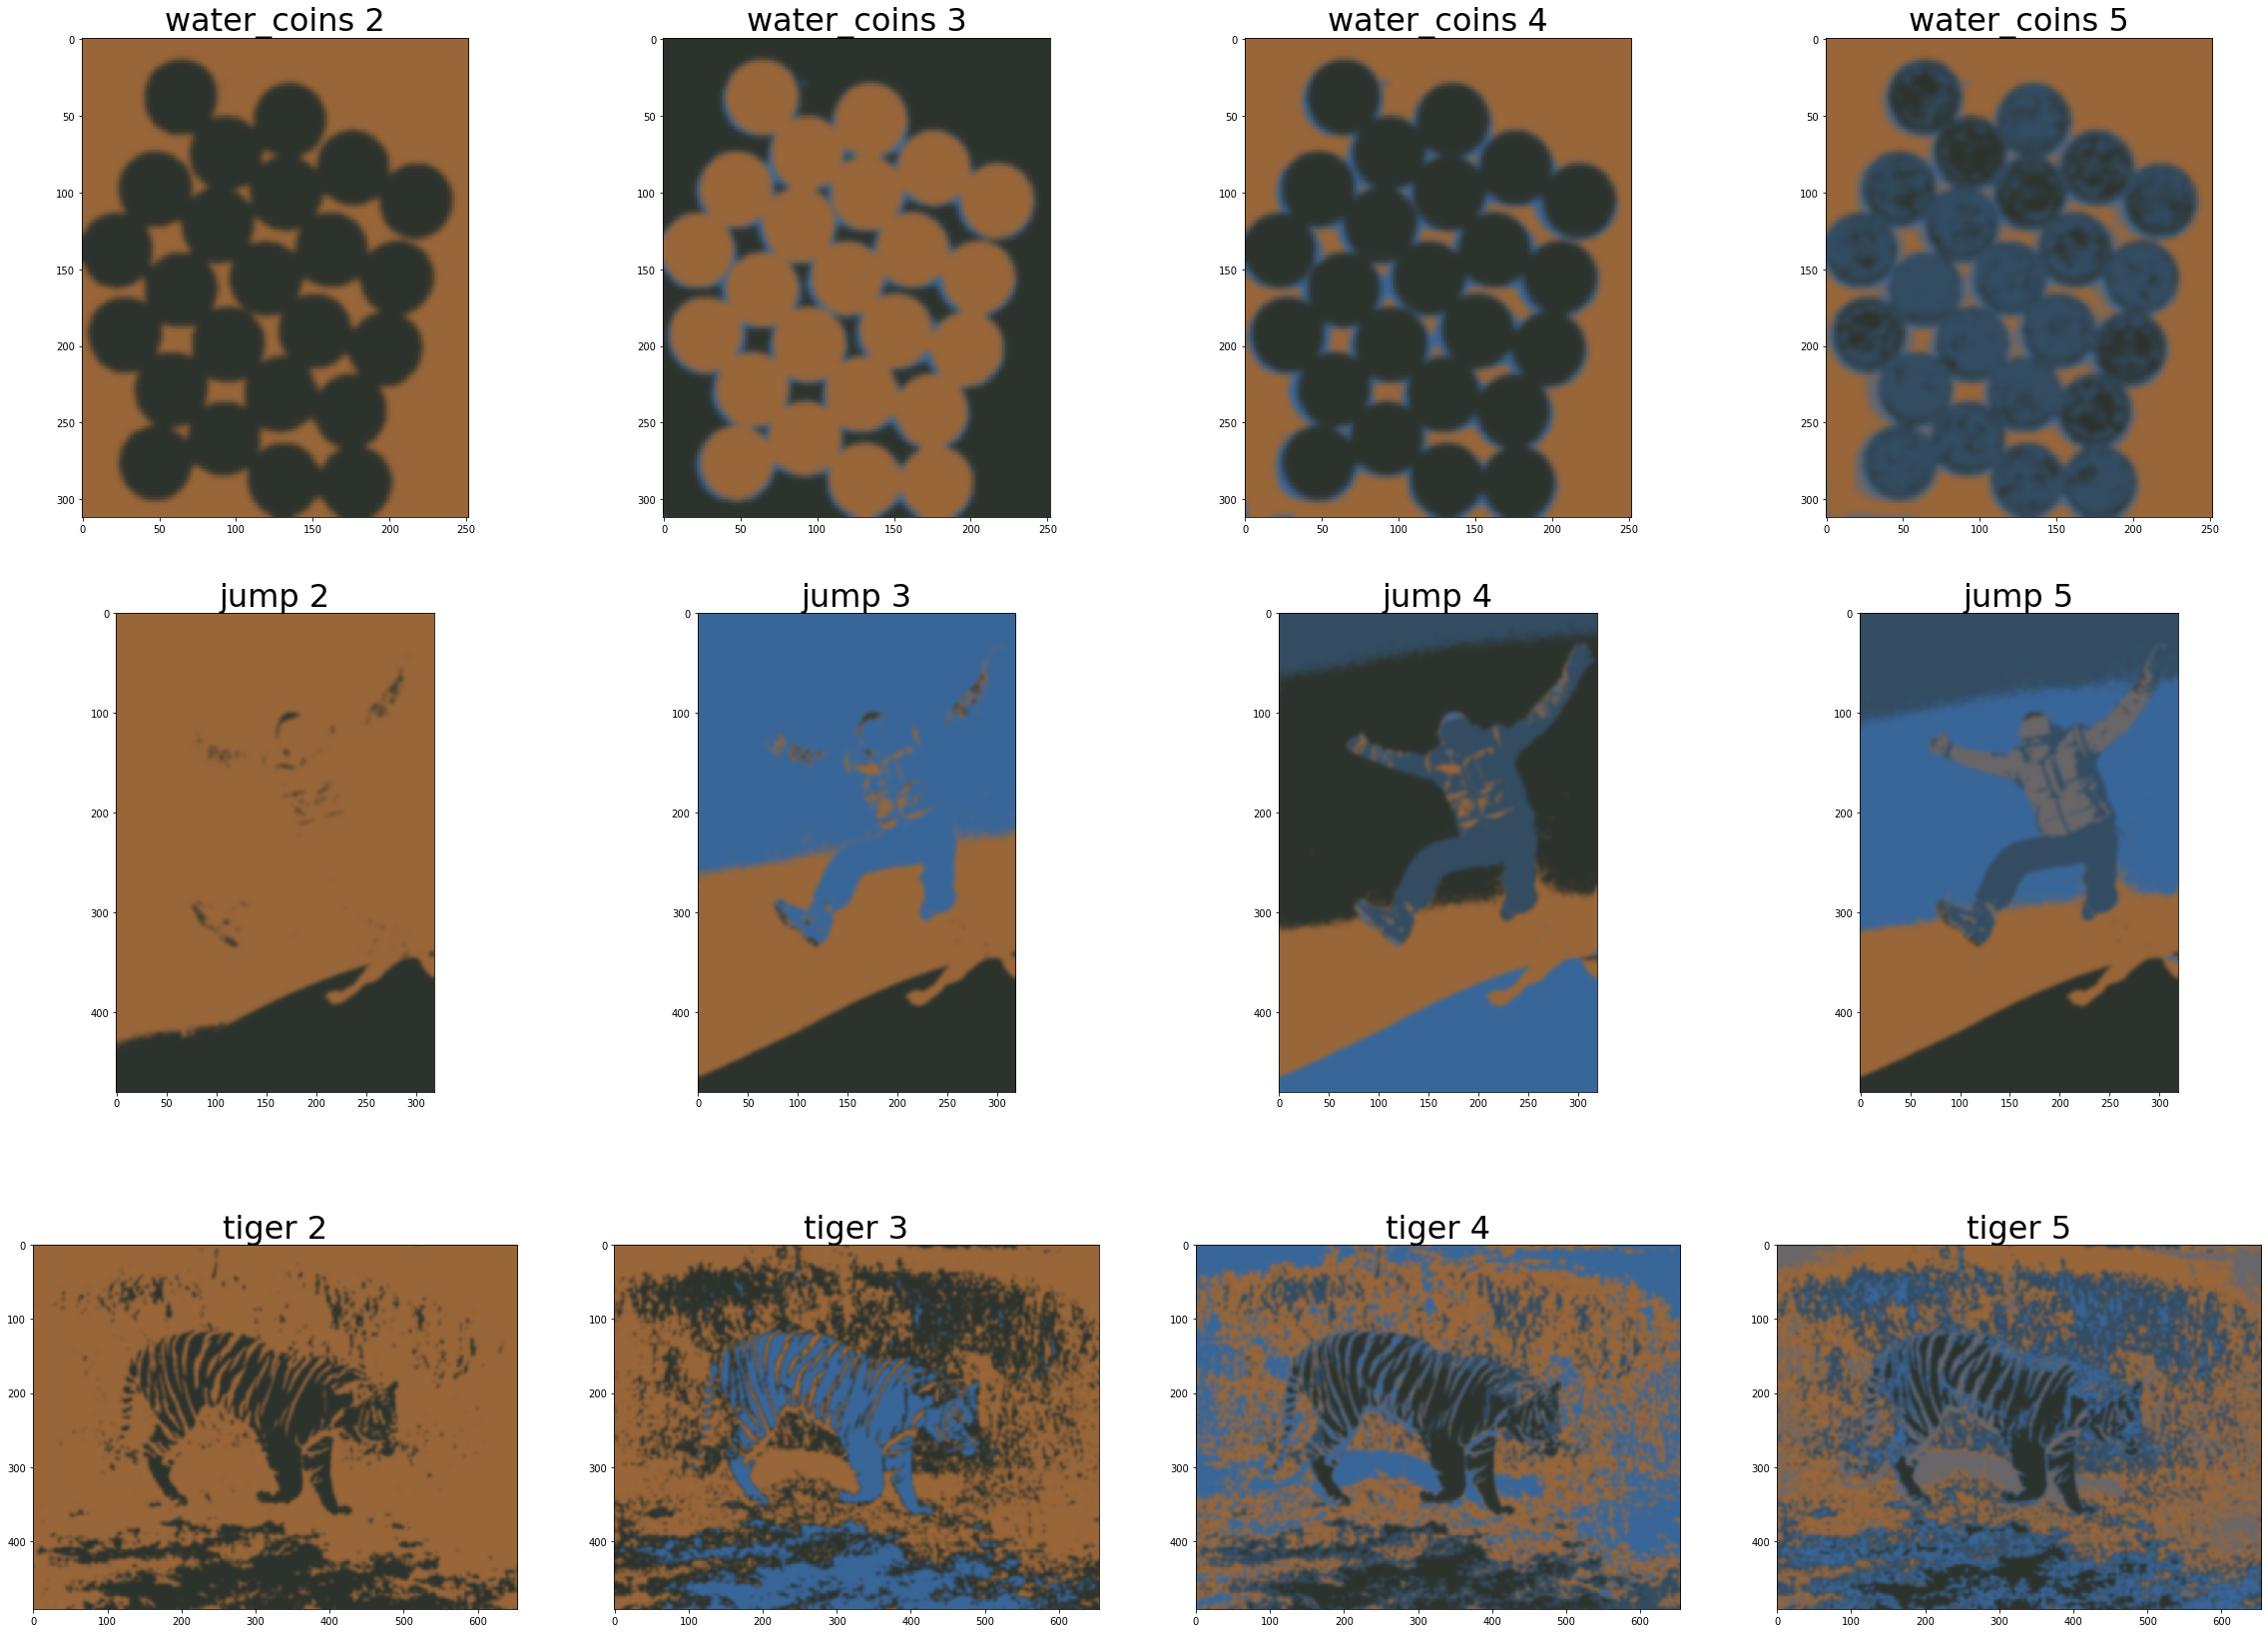

In [4]:
# Displaying final segmented outputs
itr_cnt = 0
fig = plt.figure(figsize = (40,30))
for imgName in imgNames:
    for SegCount in segmentCounts:
        outputPath = join(''.join(['Output/',str(SegCount), '_segments/', imgName , '/']))
        img = mpimg.imread(outputPath + str(img_num[itr_cnt]) + ".png")
        itr_cnt+=1
        a = fig.add_subplot(3,4,itr_cnt)
        a.set_title(imgName + " " + str(SegCount),fontsize=32)
        plt.imshow(img)